# Introduction
In this practical, we implement and train a feed-forward neural network (also known as an "MLP" for "multi-layer perceptron") on a dataset called "Fashion MNIST", consisting of small greyscale images of items of fashion.

# Learning Objectives

* Understand how to use Keras Layers to build a neural network architecture
* Understand how a model is trained and evaluated
* Understand the concept of train/validation/test split and why it's useful

In [43]:
from __future__ import print_function
import numpy as np
import keras
import keras.utils
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.optimizers import *
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import pprint
pp = pprint.PrettyPrinter(indent = 4)

# Data
In this practical, we use the Fashion MNIST dataset consisting of 70,000 greyscale images and their labels. The dataset is divided
 into 60,000 training images and 10,000 test images. The idea is to train a **classifier** to identify the class value (what type of fashion item it is) given the image. We train and *tune* a model on the 60,000 training images and then evaluate how well it classifies the 10,000 test images that the model did not see during training. This task is an example of a **supervised learning** problem, where we are given both input and labels (targets) to learn from. This is in contrast to **unsupervised learning** where we only have inputs from which to learn patterns or **reinforcement learning** where an agent learns how to maximise a reward signal through interaction with its environment. 

![Texte alternatif…](https://res.cloudinary.com/practicaldev/image/fetch/s---fNWEeWA--/c_imagga_scale,f_auto,fl_progressive,h_420,q_auto,w_1000/https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)

# Train/Validation/Test Split

When we build machine learning models, the goal is to build a model that will perform well on future data that we have not seen yet. We say that we want our models to be able to generalise well from whatever training data we can collect and do have available, to whatever data we will be applying them to in future. To do this, we split whatever data we have available into a training set, a validation set and a test set. The idea is that we train our model and use the performance on the validation set to make any adjustments to the model and its hyperparameters, but then we report the final accuracy on the test set. The test set (which we never train on), therefore acts as a proxy for our future data.

In [2]:
(train_and_validation_images, train_and_validation_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
# Construct a validation set from the last 10000 images and labels from 
# train_and_validation_images and train_and_validation_labels
validation_images = train_and_validation_images[-10000:]
validation_labels = train_and_validation_labels[-10000:]

# Construct a training set from the first 50000 images and labels.
train_images = train_and_validation_images[:50000]
train_labels = train_and_validation_labels[:50000]
# OR,
"""validation_images = train_and_validation_images[-10000:, :, :]
validation_labels = train_and_validation_labels[-10000:]

# 
train_images = train_and_validation_images[:50000, :, :]
train_labels = train_and_validation_labels[:50000]"""
# Both are correct 

'validation_images = train_and_validation_images[-10000:, :, :]\nvalidation_labels = train_and_validation_labels[-10000:]\n\n# \ntrain_images = train_and_validation_images[:50000, :, :]\ntrain_labels = train_and_validation_labels[:50000]'

In [4]:
#lets use shape attribut to understand how the shape of the validations is ?, 

validation_images.shape,validation_labels.shape,train_images.shape,train_labels.shape

((10000, 28, 28), (10000,), (50000, 28, 28), (50000,))

## Lets explain the Data :
- Each image in the dataset consists of a 28 x 28 matrix of greyscale pixels. The values are between 0 and 255 where 0 represents **black**, 255 represents **white** and there are many shades of grey in-between. Each image is assigned a corresponding numerical label, so the image in ```train_images[i]``` has its corresponding label stored in ```train_labels[i]```. We also have a lookup array called text_labels to associate a text description with each of the numerical labels. For example, the label 1 is associated with the text description "Trouser".
 ```text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']```


In [5]:
text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

- The 2 cells below demonstrate how to visualise the input data. Make sure you understand what's happening, particularly how the indices correspond to individual items in the dataset.

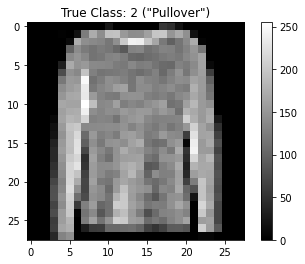

In [6]:
# By selecting matplotlib visualization we display random image from the training set 
plt.figure()
random_index = np.random.randint(0, len(train_images))
plt.imshow(train_images[random_index], cmap='gray')
plt.colorbar()
numerical_label = train_labels[random_index]
text_description = text_labels[numerical_label]
plt.title('True Class: {} ("{}")'.format(numerical_label, text_description))

plt.gca().grid(False)

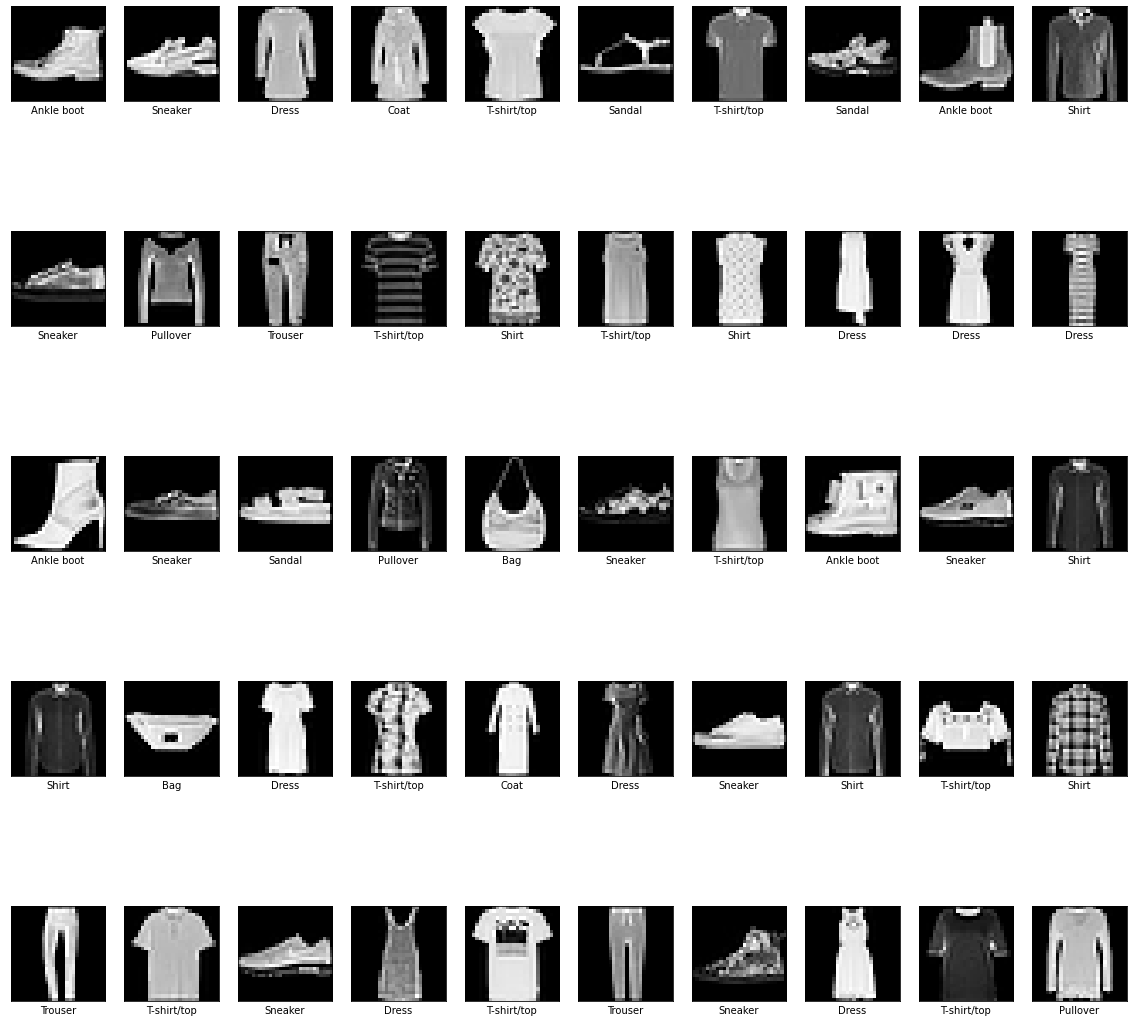

In [7]:
# Another view, showing 50 randomly selected images at a time
plt.figure(figsize=(20,20))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    
    img_index = np.random.randint(0, 50000)
    plt.imshow(train_images[img_index], cmap=plt.cm.gray)
    plt.xlabel(text_labels[train_labels[img_index]])

# Preprocess
## Flatten means : 
- Convert the **28x28** image into a flat vector of **28x28 = 784** values

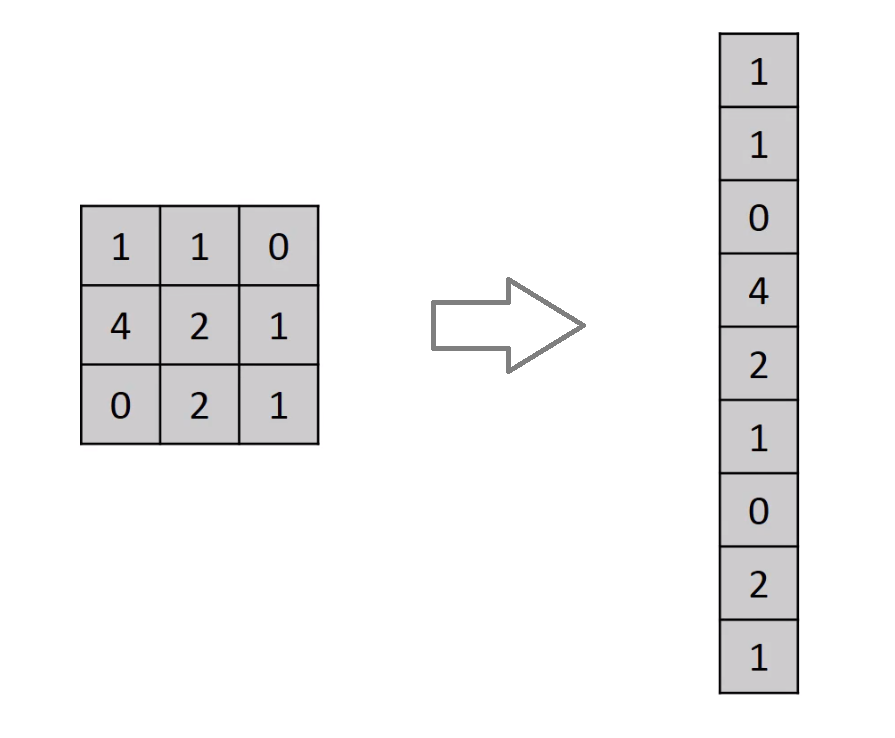




In [8]:
# Flatten

train_images_flatten = train_images.reshape(train_images.shape[0], 784)

# dimension before flattening the train_images 
print("The dimension of train_images is: ",train_images.ndim)

# dimension after flattening the train_images "train_images_fllatten"
print("The deminsion of train_images after flattening is: ",train_images_flatten.ndim)

# validation_images_flatten and test_images_flatten 
validation_images_flatten = validation_images.reshape(validation_images.shape[0], 784)
test_images_flatten = test_images.reshape(test_images.shape[0], 784)

The dimension of train_images is:  3
The deminsion of train_images after flattening is:  2


### Normalizing generally trasforming the values between 0 and 1 
For most image data, the pixel values are integers with values between 0 and 255.

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1.

It is valid for images to have pixel values in the range 0-1 and images can be viewed normally.

This can be achieved by dividing all pixels values by the largest pixel value; that is 255. This is performed across all channels, regardless of the actual range of pixel values that are present in the image.

In [9]:
# Normalize


train_images_model = train_images_flatten/255.
validation_images_model = validation_images_flatten/225.
test_images_model = test_images_flatten/255.

"""
# Optional code :
# example of pixel normalization

from numpy import asarray
from PIL import Image
# load image

pixels = asarray(train_images_flatten[0])
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))"""

"\n# Optional code :\n# example of pixel normalization\n\nfrom numpy import asarray\nfrom PIL import Image\n# load image\n\npixels = asarray(train_images_flatten[0])\n# confirm pixel range is 0-255\nprint('Data Type: %s' % pixels.dtype)\nprint('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))\n# convert from integers to floats\npixels = pixels.astype('float32')\n# normalize to the range 0-1\npixels /= 255.0\n# confirm the normalization\nprint('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))"

- In the cell below generally we used to use `keras.utils.to_categorical`, but with the last versions we have to add tf as `tf.keras.utils.to_categorical`

In [10]:
# convert class vectors to binary class matrices
train_labels_categ = tf.keras.utils.to_categorical(train_labels, 10)
validation_labels_categ = tf.keras.utils.to_categorical(validation_labels, 10)
test_labels_categ = tf.keras.utils.to_categorical(test_labels, 10)

## What happened under the ligne of code of the to_categorical:
- Example:
Again, for an array having 3 classes,` Y = {4, 8, 9, 4, 9}`

to_categorical(Y) will output
```
array([[0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0. ],
       [0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0. ],
       [0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1. ],
       [0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0. ],
       [0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1. ]]

```

[Read more about the to_categorical](https://stackoverflow.com/questions/41494625/issues-using-keras-np-utils-to-categorical/43314437)

# Train
building the ANN, and folowing instructions below to get the same number of layers 


```
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
=================================================================
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
```



In [11]:
batch_size = 128
num_classes = 10
epochs = 40


model = Sequential()
model.add(Dense(units=256, activation="relu"))
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=10, activation="softmax"))



In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(train_images_model, train_labels_categ,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(validation_images_model, validation_labels_categ))


Epoch 1/40
391/391 [==============================] - 10s 12ms/step - loss: 0.5696 - accuracy: 0.7943 - val_loss: 0.4800 - val_accuracy: 0.8311
Epoch 2/40
391/391 [==============================] - 9s 23ms/step - loss: 0.3905 - accuracy: 0.8561 - val_loss: 0.5322 - val_accuracy: 0.8303
Epoch 3/40
391/391 [==============================] - 4s 9ms/step - loss: 0.3455 - accuracy: 0.8722 - val_loss: 0.3734 - val_accuracy: 0.8715
Epoch 4/40
391/391 [==============================] - 4s 10ms/step - loss: 0.3179 - accuracy: 0.8819 - val_loss: 0.3984 - val_accuracy: 0.8653
Epoch 5/40
391/391 [==============================] - 8s 21ms/step - loss: 0.2977 - accuracy: 0.8894 - val_loss: 0.3634 - val_accuracy: 0.8741
Epoch 6/40
391/391 [==============================] - 8s 19ms/step - loss: 0.2797 - accuracy: 0.8958 - val_loss: 0.3406 - val_accuracy: 0.8862
Epoch 7/40
391/391 [==============================] - 5s 12ms/step - loss: 0.2663 - accuracy: 0.9006 - val_loss: 0.4118 - val_accuracy: 0.8740

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


# Test

In [14]:
score = model.evaluate(test_images_model, test_labels_categ, verbose=0)
print('Test accuracy:', score[1])
# You should be able to get,at least, 88% accuracy

Test accuracy: 0.8896999955177307


In [15]:
test_logits = model.predict(test_images_flatten)

313/313 [==============================] - 1s 4ms/step


In [16]:
test_logits

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
test_predictions = np.argmax(test_logits, axis=1)


In [18]:
test_predictions

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

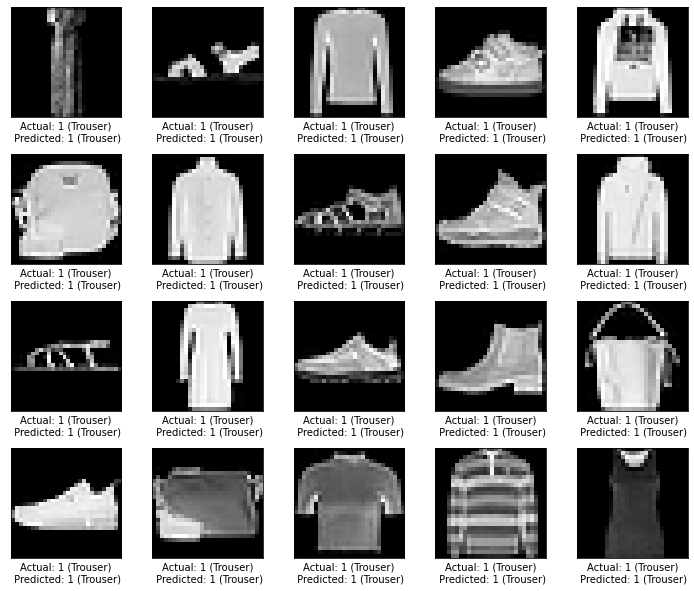

In [19]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    
    img_index = np.random.randint(0, 10000)
    plt.imshow(test_images[img_index], cmap=plt.cm.gray)
    
    actual_label = int(1)
    predicted_label = int(1)
    
    plt.xlabel("Actual: {} ({})\n Predicted: {} ({})".format(
        actual_label, text_labels[actual_label], predicted_label, text_labels[predicted_label]
    ))
    
plt.tight_layout()
plt.show()

- It's obvious that the accuracy is very low with the example above, which we have to deal well with the hyperparameters, and making changes, optimisations will help us to improve the accuracy each time

- lets change some activation functions and optimizers, number of epochs...etc
  

In [20]:
# Model optimizations and accuracy improvements 
batch_size = 128
num_classes = 10
epochs = 40


model = Sequential()
model.add(Dense(units=256, activation="relu", kernel_initializer="uniform"))
model.add(Dense(units=128, activation="relu",kernel_initializer="uniform"))
model.add(Dense(units=10, activation="relu"))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(train_images_model, train_labels_categ,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(validation_images_model, validation_labels_categ))



Epoch 1/40
391/391 [==============================] - 10s 22ms/step - loss: nan - accuracy: 0.1312 - val_loss: nan - val_accuracy: 0.1023
Epoch 2/40
391/391 [==============================] - 4s 10ms/step - loss: nan - accuracy: 0.0995 - val_loss: nan - val_accuracy: 0.1023
Epoch 3/40
391/391 [==============================] - 3s 9ms/step - loss: nan - accuracy: 0.0995 - val_loss: nan - val_accuracy: 0.1023
Epoch 4/40
391/391 [==============================] - 8s 20ms/step - loss: nan - accuracy: 0.0995 - val_loss: nan - val_accuracy: 0.1023
Epoch 5/40
391/391 [==============================] - 4s 9ms/step - loss: nan - accuracy: 0.0995 - val_loss: nan - val_accuracy: 0.1023
Epoch 6/40
391/391 [==============================] - 4s 9ms/step - loss: nan - accuracy: 0.0995 - val_loss: nan - val_accuracy: 0.1023
Epoch 7/40
391/391 [==============================] - 4s 10ms/step - loss: nan - accuracy: 0.0995 - val_loss: nan - val_accuracy: 0.1023
Epoch 8/40
391/391 [=======================

# Improving ANN:
We can also add the technque GridSearch to optimize the model :



In [50]:

# # Dropout regularization to reduce overfitting if needed (in part 2 above)

# # Tuning the ANN
# from keras.wrappers.scikit_learn import KerasClassifier


# def build_classifier(optimizer):
#     classifier = Sequential()
#     classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
#     classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
#     classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'sigmoid'))
#     classifier.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
#     return classifier
# classifier = KerasClassifier(build_fn = build_classifier)
# parameters = {'batch_size': [25, 32], 'epochs': [10, 50], 'optimizer': ['adam', 'rmsprop']} # create dictionary for parameters to optimize
# grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = 'accuracy', cv = 10)
# grid_result = grid_search.fit(to_categorical(train_images), train_labels_categ)
# best_parameters = grid_search.best_params_
# best_accuracy = grid_search.best_score_

In [35]:
batch_size = [20, 50, 100][:1]

epochs = [1, 20, 50][:1]

initializer = ['lecun_uniform', 'normal', 'he_normal', 'he_uniform'][:1]

learning_rate = [0.1, 0.001, 0.02][:1]

dropout_rate = [0.3, 0.2, 0.8][:1]

num_unit = [10, 5][:1]

activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'][:1]

optimizer = [SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam][:1]

In [36]:
def build_model(optimizer, learning_rate, activation, dropout_rate,
                initializer,num_unit):
    keras.backend.clear_session()
    model = Sequential()
    model.add(Dense(num_unit, kernel_initializer=initializer,
                    activation=activation, input_shape=(784,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_unit, kernel_initializer=initializer,
                    activation=activation))
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer(lr=learning_rate),
                  metrics=['accuracy'])
    return model

In [46]:
parameters = dict(batch_size = batch_size,
                  epochs = epochs,
                  dropout_rate = dropout_rate,
                  num_unit = num_unit,
                  initializer = initializer,
                  learning_rate = learning_rate,
                  activation = activation,
                  optimizer = optimizer)

model = KerasClassifier(build_fn=build_model, verbose=0)

models = GridSearchCV(estimator = model, param_grid=parameters, n_jobs=1)

C:\Users\hp\AppData\Local\Temp\ipykernel_7444\2268028699.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, verbose=0)


In [47]:
best_model = models.fit(train_images_model, train_labels_categ)
print('Best model :')
pp.pprint(best_model.best_params_)

C:\Users\hp\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\hp\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\hp\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\hp\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\hp\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().

Best model :
{   'activation': 'relu',
    'batch_size': 20,
    'dropout_rate': 0.3,
    'epochs': 1,
    'initializer': 'lecun_uniform',
    'learning_rate': 0.1,
    'num_unit': 10,
    'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
